In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [14]:
df = pd.read_csv("edges.csv") # open file
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95497 entries, 0 to 95496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   # source  95497 non-null  int64
 1    target   95497 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


In [15]:
G = nx.from_pandas_edgelist(df,"# source", " target",create_using=nx.Graph) # Create network from data_frame

In [16]:
number_nodes_k = []                             # List of number of nodes (k_core)
k_core = []                                     # List of all k_core
degree_list = [v for d,v in G.degree()]         # List of degree for all nodes

In [17]:
# np.unique select just single values in degree_list
for i in np.unique(degree_list):
    G_ = nx.k_core(G,k=i)                       # Define subgraph from k_core
    k_core.append(i)                            # Update k_core list
    number_nodes_k.append(G_.number_of_nodes()) # Select number of nodes in subgraph
    if(G_.number_of_nodes()==0):
        G_.clear()                                  
        break
    G_.clear()                                  # Delete subgraph of memory 

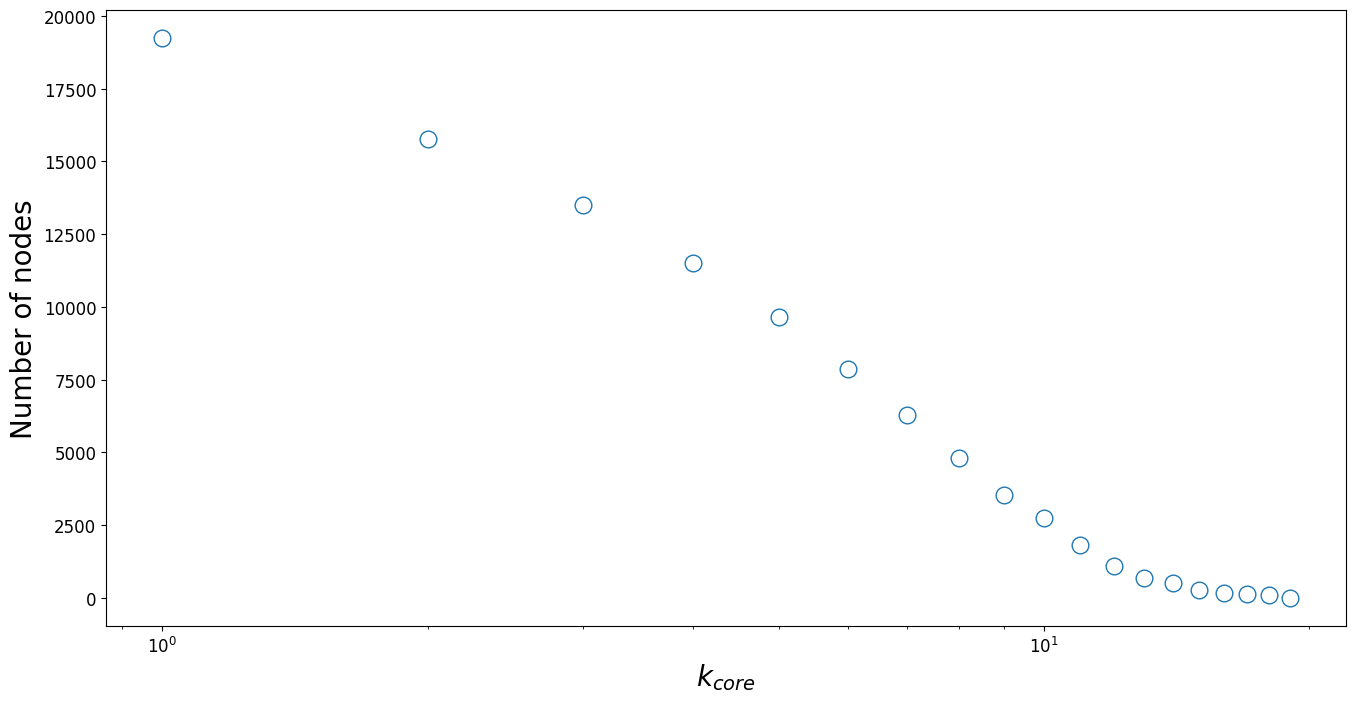

In [18]:
# Plot number_of_nodes(k_core)
plt.figure(figsize=(16,8))
ms= 12
plt.plot(k_core,number_nodes_k,'o',ms=ms,mec=None,markerfacecolor='w')
plt.xscale("log")
plt.ylabel("Number of nodes",fontsize=20)
plt.xlabel(r"$k_{core}$",fontsize=20)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.show()

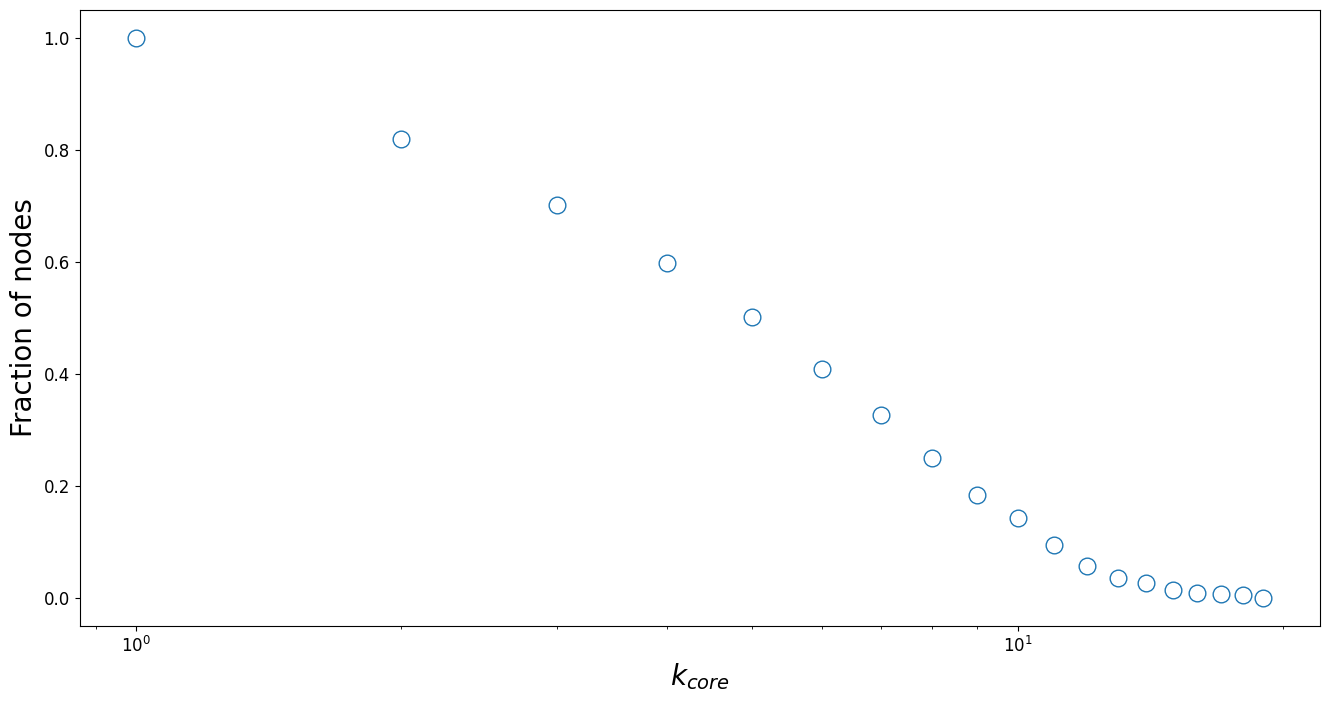

In [19]:
# Plot fraction_of_nodes(k_core)

norm_number_nodes = [number_nodes_k[i]/G.number_of_nodes() for i in range(len(number_nodes_k))] # number_of_nodes(k_core)/number_of_nodes_initial

plt.figure(figsize=(16,8))
ms= 12
plt.plot(k_core,norm_number_nodes,'o',ms=ms,mec=None,markerfacecolor='w')
plt.xscale("log")
plt.ylabel("Fraction of nodes",fontsize=20)
plt.xlabel(r"$k_{core}$",fontsize=20)
plt.xticks(fontsize=12)  # Adjust the fontsize as needed for the x-axis ticks
plt.yticks(fontsize=12)  # Adjust the fontsize as needed for the y-axis ticks
plt.show()

In [20]:
# Pairing to gml to read in gephi with the network with the highest k-core
G_min = nx.k_core(G,k=k_core_min)  # Network with k_core_min
print(G_min.number_of_nodes())
node_labels = pd.read_csv("nodes.csv")   # load nodeList.csv
node_labels = node_labels.iloc[:, [0,1]] # Select just columns (index, name)
node_labels.info()


103
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19428 entries, 0 to 19427
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   # index  19428 non-null  int64 
 1    name    19427 non-null  object
dtypes: int64(1), object(1)
memory usage: 303.7+ KB


In [21]:
#node_labels
k_core_min = len(number_nodes_k)-1 # k_core min to graph non-empty
G_min = nx.k_core(G,k=k_core_min)  # Network with k_core_min

edges = G_min.edges() # Create iterator about edges graph

new_source_list = [] # New source list with name in node_label
new_target_list = [] # New target list with name in node_label
'''
for edge in edges:
    source = edge[0]
    target = edge[1]
    print(source,target)
'''
for edge in edges: # Run for all edges
    w_s = np.where(node_labels["# index"]==edge[0]) # select the line where "node_id"=element in source
    w_t = np.where(node_labels["# index"]==edge[1]) # select the line where "node_id"=element in target
    
    author_s = node_labels[" name"][w_s[0][0]]  # selects the corresponding element in the author column (source)
    author_t = node_labels[" name"][w_t[0][0]]  # selects the corresponding element in the author column (target)
    
    new_source_list.append(author_s)
    new_target_list.append(author_t)
a = [(new_source_list[i],new_target_list[i]) for i in range(G_min.number_of_edges())]
con__ = [(new_source_list[i],new_target_list[i]) for i in range(G_min.number_of_edges())] # Create new tuples in list (source
G__=nx.from_edgelist(con__) # Create graph in networkx from new tuples
nx.write_gml(G__,"network_k_min.gml",stringizer=None) # save network in .gml extension to read in gephi

In [23]:
#Vou utilizar o Pyvis pra plotar a sub-rede de k-core maximo. ANIMADA!!
#!pip install pyvis
from pyvis.network import Network

In [50]:
#Criando a rede no pyvis.
net = Network()

#Desenhando os nós a partir do grafo do networkx.
for node in G__.nodes():
    net.add_node(node)

#Desenhando as arestas a partir do grafo do networkx.
for edge in G__.edges():
    net.add_edge(edge[0], edge[1])

# Calculando os tamanhos dos nós com base no grau dos nós.
node_sizes = dict(G__.degree)

scale=10 # Escala para aumentar os tamanhos dos nós.

#Updating dict
node_sizes.update((x, scale*y) for x, y in node_sizes.items())

#Configurando os atributos dos nós
nx.set_node_attributes(G__,node_sizes,'size')

#Definindo uma padr]ao de vizualização no navegador
G2 = Network(height="1000px", width="100%",font_color='White',bgcolor="#222222",directed=False,select_menu=True)
G2.from_nx(G__)

#Colocando uma área de configuração de física
G2.show_buttons(filter_=['physics'])

# Aplique o layout de mola do NetworkX para organizar os nós
G2.barnes_hut()

#Salvando o grafo em um arquivo HTML
G2.save_graph('grafo_animado.html')